Importing needed libraries

In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as trfms
import torchsummary

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torch.amp import autocast, GradScaler
from datasets import load_from_disk
from tqdm import tqdm
from src.model import SwinTransformer
from src.utils import mask_from_pred

/home/denis/Coding/projects/TESTImageSegmentation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selecting CUDA device if available. Set multiprocessing method to 'spawn' instead of 'fork' as it works better on UNIX-system.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading dataset

In [3]:
NUM_CLASSES = 34

dataset = load_from_disk("./data/urbansyncityscapes")
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Some samples

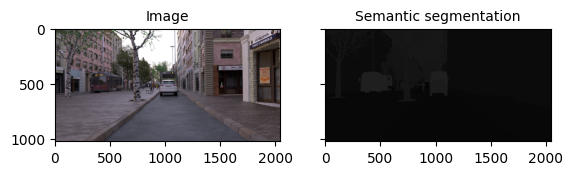

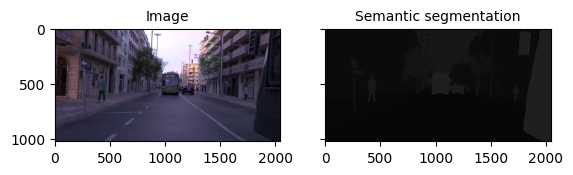

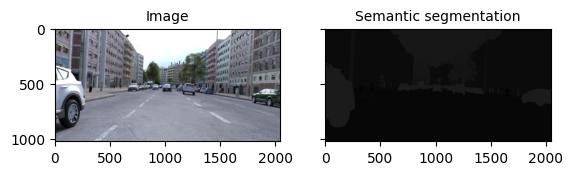

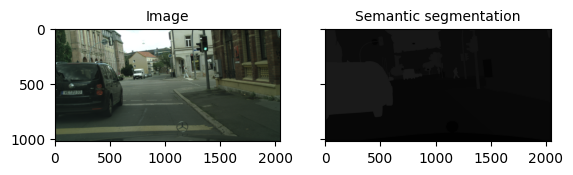

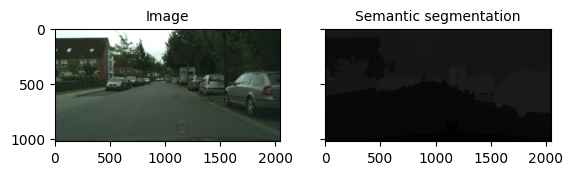

In [4]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1, 2, sharey=True)
    ax1.imshow(image)
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(semantic_segmentation)
    ax2.set_title('Semantic segmentation', fontsize='medium')


Specifying augmentation for train and validation set. Test set would be used without any augmentation. 

In [5]:
class InstanceAugmentation:
    """
    Transformation of both image and mask. Geometric transformation would be
    in alignment with each other. Color transformation is applied specifically
    for image.
    """
    def __init__(self, geometry_transform = None, color_transform = None):
        self.geometry_transform = geometry_transform
        self.color_transform = color_transform

    def __call__(self, image, mask):
        if self.geometry_transform:
            seed = random.randint(0, 2**32)
            torch.manual_seed(seed)
            image = self.geometry_transform(image)
            torch.manual_seed(seed)
            mask = self.geometry_transform(mask)

        if self.color_transform:
            image = self.color_transform(image)

        return image, mask

In [6]:
train_transforms_geometry = trfms.Compose([
    trfms.Resize(size=(512, 1024)),
    trfms.RandomHorizontalFlip(),
    trfms.RandomApply(transforms=[
        trfms.Resize(size=(512, 512))
    ], p=0.5),
    trfms.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3), scale=(0.5, 1.5))
])
train_transforms_color = trfms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.4, hue=0.3)

train_transform = InstanceAugmentation(train_transforms_geometry, train_transforms_color)

In [7]:
val_transforms_geometry = trfms.Compose([
    trfms.Resize(size=(512, 1024)),
    trfms.RandomHorizontalFlip(),
    trfms.RandomAffine(degrees=(-15, 15), scale=(0.8, 1.2)),
])
val_transforms_color = trfms.ColorJitter(brightness=0.1, contrast=0.1)

val_transform = InstanceAugmentation(val_transforms_geometry, val_transforms_color)

Augmented samples

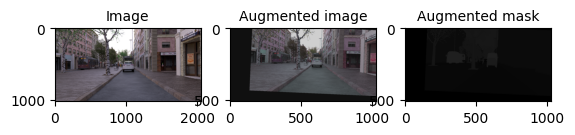

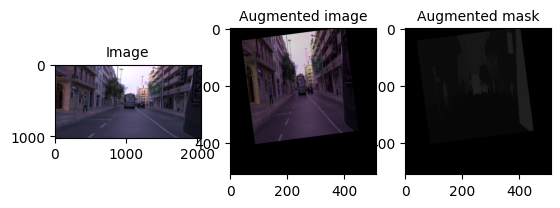

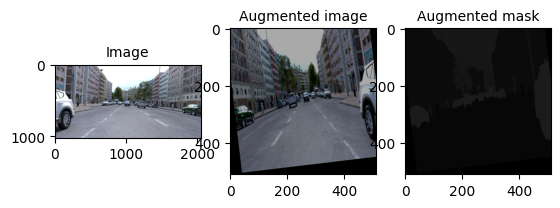

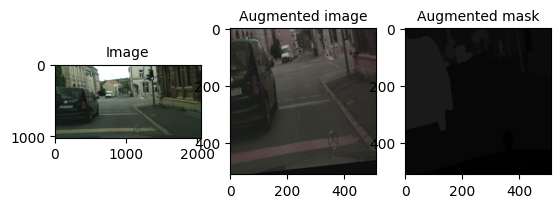

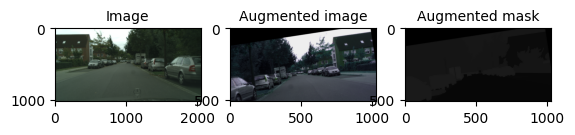

In [8]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    aug_image, aug_mask = train_transform(image, semantic_segmentation)
    fig = plt.figure()
    ax1, ax2, ax3 = fig.subplots(1, 3)
    ax1.imshow(np.array(image))
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(aug_image)
    ax2.set_title('Augmented image', fontsize='medium')
    ax3.imshow(aug_mask)
    ax3.set_title('Augmented mask', fontsize='medium')

Making a pytorch Dataset compatible with transformations 

In [9]:
def unwrap_mask(mask : torch.Tensor) -> torch.Tensor:
    assert len(mask.shape) == 2, f"Mask should be a tensor of shape (H, W), got {mask.shape}!"
    unwrapped = []
    for i in range(NUM_CLASSES):
        unwrapped.append((mask == i*torch.ones_like(mask)))
    return torch.stack(unwrapped, dim=-1).float().to(mask.device)

In [10]:
class StreetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform  = None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx : int):
        sample = self.dataset[idx]
        image = sample['image']
        mask = sample['semantic_segmentation']

        if self.transform:
            image, mask = self.transform(image, mask)

        image = torch.Tensor(np.array(image)).float()/255
        mask = torch.Tensor(np.array(mask)).long()[:, :, 0]
        return image, mask

In [11]:
train_ds = StreetSegmentationDataset(dataset_train, train_transform)
val_ds = StreetSegmentationDataset(dataset_val, val_transform)
test_ds = StreetSegmentationDataset(dataset_test)

In [12]:
def collate_fn(batch):
    images, masks = zip(*batch)
    max_height = max(img.shape[0] for img in images)
    max_width = max(img.shape[1] for img in images)

    padded_images = []
    padded_masks = []
    original_sizes = []
    for img, mask in zip(images, masks):
        height, width, channels = img.shape
        padded_img = torch.zeros((max_height, max_width, channels), dtype=img.dtype)
        padded_img[:height, :width, :] = img

        padded_mask = torch.zeros((max_height, max_width), dtype=mask.dtype)
        padded_mask[:height, :width] = mask

        padded_images.append(padded_img)
        padded_masks.append(padded_mask)
        original_sizes.append((height, width))

    padded_images = torch.stack(padded_images, dim=0)
    padded_masks = torch.stack(padded_masks, dim=0)

    return padded_images, padded_masks, original_sizes

In [13]:
BATCH_SIZE = 4

train_dataloader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dataloader = DataLoader(val_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)

Using Swin Transformer architecture neural network

In [14]:
model = SwinTransformer(NUM_CLASSES, 64).to(device)
torchsummary.summary(model, (512, 1024, 3), batch_size=BATCH_SIZE, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 256, 512]           1,792
            Conv2d-2            [4, 64, 37, 74]         200,768
    PatchEmbedding-3              [4, 2738, 64]               0
         LayerNorm-4              [4, 2738, 64]             128
MultiheadAttention-5  [[-1, 2738, 64], [-1, 2738, 2738]]               0
         LayerNorm-6              [4, 2738, 64]             128
            Linear-7             [4, 2738, 256]          16,640
              GELU-8             [4, 2738, 256]               0
            Linear-9              [4, 2738, 64]          16,448
        SwinBlock-10            [4, 64, 37, 74]               0
           Conv2d-11             [4, 64, 6, 11]         200,768
   PatchEmbedding-12                [4, 66, 64]               0
        LayerNorm-13                [4, 66, 64]             128
MultiheadAttention-14  [[-1, 6

Specifying loss function

In [15]:
cross_entropy_loss = nn.CrossEntropyLoss()

def loss_fn(y_pred : torch.Tensor, y_true : torch.Tensor):
    """
    Computes CrossEntropy Loss
    y_pred : torch.Tensor - Model prediction of shape (batch_size, height, width, num_classes), dtype=float
    y_true : torch.Tensor - Target mask of shape (batch_size, height, width), dtype=long
    """
    y_pred = y_pred.permute(0, 3, 1, 2)
    loss = cross_entropy_loss(y_pred, y_true)
    return loss


Specifying IntersectionOverUnion metrics function

In [16]:
def intersection_over_union(y_pred : torch.Tensor, y_true : torch.Tensor):
    """
    Computes IntersectionOverUnion metrics
    """
    pred_mask = mask_from_pred(y_pred).long()
    intersection = (pred_mask & y_true).float().sum((1, 2))
    union = (pred_mask | y_true).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

Dictionary to keep loss and metrics during training and validation

In [17]:
history = {
    "train_loss" : [float('inf')],
    "train_iou" : [0.0],
    "val_loss" : [float('inf')],
    "val_iou" : [0.0]
}

Specifying training and validation algorithms

In [18]:
def train(model, dataloader, optimizer, scaler, scheduler = None, accumulation_steps : int = 4):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.3f}, IoU: {history['train_iou'][-1]:.3f}")
    total_loss = 0
    out_of_mem = 0
    for batch_idx, (images, masks, _) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        try:
            with autocast('cuda'):
                prediction = model(images)
                loss_value = loss_fn(prediction, masks)
                iou_metrics = intersection_over_union(prediction, masks)

            scaler.scale(loss_value).backward()

            if (batch_idx+1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if scheduler:
                scheduler.step(loss_value)

            total_loss += loss_value.item()
            if batch_idx % 10 == 0:
                history['train_loss'].append(loss_value.item())
                history['train_iou'].append(iou_metrics)
                pbar.set_description(f"Train loss: {history['train_loss'][-1]:.3f}, IoU: {history['train_iou'][-1]:.3f}")

        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e

        del images, masks
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return total_loss/(batch_idx+1)

def validate(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Validation loss: {history['val_loss'][-1]:.3f}, IoU: {history['val_iou'][-1]:.3f}")
    total_loss = 0
    out_of_mem = 0
    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            try:
                prediction = model(images)
                loss_value = loss_fn(prediction, masks)
                iou_metrics = intersection_over_union(prediction, masks)

            except RuntimeError as e:
                if 'out of memory' in str(e):
                    out_of_mem += 1
                    torch.cuda.empty_cache()
                else:
                    raise e

            total_loss += loss_value.item()
            if batch_idx % 10 == 0:
                history['val_loss'].append(loss_value.item())
                history['val_iou'].append(iou_metrics)
                pbar.set_description(f"Validation loss: {history['val_loss'][-1]:.3f}, IoU: {history['val_iou'][-1]:.3f}")

            del images, masks
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")

    return total_loss/(batch_idx+1)

Specifying optimizer and scheduler. Also using scaler to make computation "less expensive"

In [19]:
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)
scaler = GradScaler()

Starting learning process. Saving models, which achieved the least loss value on validation set

In [39]:
EPOCHS = 100
checkpoint_path = "./checkpoint"
os.makedirs(checkpoint_path, exist_ok=True)
best_val_loss = float('inf')

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    mean_train_loss = train(model, train_dataloader, optimizer, scaler, scheduler)
    print(f"Average training loss: {mean_train_loss:.3f}")
    mean_val_loss = validate(model, val_dataloader)
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        checkpoint_file = os.path.join(checkpoint_path, f'swin_seg_best.pth')
        torch.save(model.state_dict(), checkpoint_file)
        print(f"New best model saved with val_loss: {best_val_loss:.3f} at {checkpoint_file}")
    else:
        print(f"No improvement in validation loss ({mean_val_loss:.3f})")


Training epoch: 1/100


Train loss: 3.448, IoU: 0.171: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.448


Validation loss: 3.495, IoU: 0.291: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.490 at ./checkpoint/swin_seg_best.pth
Training epoch: 2/100


Train loss: 3.444, IoU: 0.191: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.447


Validation loss: 3.510, IoU: 0.239: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.490 at ./checkpoint/swin_seg_best.pth
Training epoch: 3/100


Train loss: 3.443, IoU: 0.240: 100%|██████████| 1928/1928 [13:31<00:00,  2.37it/s]


Average training loss: 3.446


Validation loss: 3.486, IoU: 0.284: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.490)
Training epoch: 4/100


Train loss: 3.466, IoU: 0.144: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.445


Validation loss: 3.463, IoU: 0.213: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.489 at ./checkpoint/swin_seg_best.pth
Training epoch: 5/100


Train loss: 3.413, IoU: 0.107: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.443


Validation loss: 3.466, IoU: 0.258: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.488 at ./checkpoint/swin_seg_best.pth
Training epoch: 6/100


Train loss: 3.462, IoU: 0.220: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.442


Validation loss: 3.479, IoU: 0.210: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.487 at ./checkpoint/swin_seg_best.pth
Training epoch: 7/100


Train loss: 3.410, IoU: 0.095: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.440


Validation loss: 3.497, IoU: 0.284: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.486 at ./checkpoint/swin_seg_best.pth
Training epoch: 8/100


Train loss: 3.438, IoU: 0.147: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.439


Validation loss: 3.504, IoU: 0.262: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.485 at ./checkpoint/swin_seg_best.pth
Training epoch: 9/100


Train loss: 3.443, IoU: 0.193: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.438


Validation loss: 3.513, IoU: 0.295: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.485 at ./checkpoint/swin_seg_best.pth
Training epoch: 10/100


Train loss: 3.440, IoU: 0.140: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.437


Validation loss: 3.453, IoU: 0.257: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.483 at ./checkpoint/swin_seg_best.pth
Training epoch: 11/100


Train loss: 3.463, IoU: 0.206: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.436


Validation loss: 3.501, IoU: 0.252: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.482 at ./checkpoint/swin_seg_best.pth
Training epoch: 12/100


Train loss: 3.461, IoU: 0.182: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.433


Validation loss: 3.477, IoU: 0.273: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


No improvement in validation loss (3.483)
Training epoch: 13/100


Train loss: 3.440, IoU: 0.155: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.433


Validation loss: 3.471, IoU: 0.242: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.481 at ./checkpoint/swin_seg_best.pth
Training epoch: 14/100


Train loss: 3.444, IoU: 0.141: 100%|██████████| 1928/1928 [13:28<00:00,  2.38it/s]


Average training loss: 3.431


Validation loss: 3.471, IoU: 0.221: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.480 at ./checkpoint/swin_seg_best.pth
Training epoch: 15/100


Train loss: 3.421, IoU: 0.171: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.430


Validation loss: 3.487, IoU: 0.243: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


No improvement in validation loss (3.480)
Training epoch: 16/100


Train loss: 3.420, IoU: 0.130: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.429


Validation loss: 3.490, IoU: 0.244: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.479 at ./checkpoint/swin_seg_best.pth
Training epoch: 17/100


Train loss: 3.399, IoU: 0.168: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.427


Validation loss: 3.474, IoU: 0.274: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.478 at ./checkpoint/swin_seg_best.pth
Training epoch: 18/100


Train loss: 3.425, IoU: 0.155: 100%|██████████| 1928/1928 [13:26<00:00,  2.39it/s]


Average training loss: 3.425


Validation loss: 3.498, IoU: 0.310: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.477 at ./checkpoint/swin_seg_best.pth
Training epoch: 19/100


Train loss: 3.407, IoU: 0.174: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.424


Validation loss: 3.469, IoU: 0.251: 100%|██████████| 276/276 [01:39<00:00,  2.78it/s]


New best model saved with val_loss: 3.477 at ./checkpoint/swin_seg_best.pth
Training epoch: 20/100


Train loss: 3.420, IoU: 0.158: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.422


Validation loss: 3.473, IoU: 0.236: 100%|██████████| 276/276 [01:39<00:00,  2.79it/s]


New best model saved with val_loss: 3.475 at ./checkpoint/swin_seg_best.pth
Training epoch: 21/100


Train loss: 3.418, IoU: 0.171: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.421


Validation loss: 3.454, IoU: 0.231: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.474 at ./checkpoint/swin_seg_best.pth
Training epoch: 22/100


Train loss: 3.420, IoU: 0.119: 100%|██████████| 1928/1928 [13:28<00:00,  2.38it/s]


Average training loss: 3.420


Validation loss: 3.477, IoU: 0.206: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


No improvement in validation loss (3.474)
Training epoch: 23/100


Train loss: 3.433, IoU: 0.218: 100%|██████████| 1928/1928 [13:27<00:00,  2.39it/s]


Average training loss: 3.418


Validation loss: 3.473, IoU: 0.239: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.471 at ./checkpoint/swin_seg_best.pth
Training epoch: 24/100


Train loss: 3.475, IoU: 0.229: 100%|██████████| 1928/1928 [13:28<00:00,  2.38it/s]


Average training loss: 3.417


Validation loss: 3.474, IoU: 0.233: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.471)
Training epoch: 25/100


Train loss: 3.408, IoU: 0.123: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.415


Validation loss: 3.492, IoU: 0.278: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


New best model saved with val_loss: 3.470 at ./checkpoint/swin_seg_best.pth
Training epoch: 26/100


Train loss: 3.446, IoU: 0.219: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.414


Validation loss: 3.436, IoU: 0.190: 100%|██████████| 276/276 [01:39<00:00,  2.77it/s]


No improvement in validation loss (3.470)
Training epoch: 27/100


Train loss: 3.458, IoU: 0.223: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.412


Validation loss: 3.466, IoU: 0.246: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.468 at ./checkpoint/swin_seg_best.pth
Training epoch: 28/100


Train loss: 3.402, IoU: 0.209: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.410


Validation loss: 3.471, IoU: 0.301: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.468 at ./checkpoint/swin_seg_best.pth
Training epoch: 29/100


Train loss: 3.396, IoU: 0.160: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.409


Validation loss: 3.452, IoU: 0.198: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.468)
Training epoch: 30/100


Train loss: 3.398, IoU: 0.169: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.407


Validation loss: 3.449, IoU: 0.268: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.466 at ./checkpoint/swin_seg_best.pth
Training epoch: 31/100


Train loss: 3.420, IoU: 0.187: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.406


Validation loss: 3.456, IoU: 0.239: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.465 at ./checkpoint/swin_seg_best.pth
Training epoch: 32/100


Train loss: 3.447, IoU: 0.234: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.403


Validation loss: 3.453, IoU: 0.223: 100%|██████████| 276/276 [01:41<00:00,  2.73it/s]


New best model saved with val_loss: 3.464 at ./checkpoint/swin_seg_best.pth
Training epoch: 33/100


Train loss: 3.410, IoU: 0.188: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.402


Validation loss: 3.467, IoU: 0.247: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.463 at ./checkpoint/swin_seg_best.pth
Training epoch: 34/100


Train loss: 3.388, IoU: 0.137: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.401


Validation loss: 3.461, IoU: 0.266: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.461 at ./checkpoint/swin_seg_best.pth
Training epoch: 35/100


Train loss: 3.430, IoU: 0.173: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.398


Validation loss: 3.473, IoU: 0.241: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


No improvement in validation loss (3.461)
Training epoch: 36/100


Train loss: 3.420, IoU: 0.153: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.397


Validation loss: 3.432, IoU: 0.206: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.460 at ./checkpoint/swin_seg_best.pth
Training epoch: 37/100


Train loss: 3.417, IoU: 0.179: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.396


Validation loss: 3.481, IoU: 0.262: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.459 at ./checkpoint/swin_seg_best.pth
Training epoch: 38/100


Train loss: 3.403, IoU: 0.162: 100%|██████████| 1928/1928 [13:35<00:00,  2.36it/s]


Average training loss: 3.395


Validation loss: 3.431, IoU: 0.219: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.457 at ./checkpoint/swin_seg_best.pth
Training epoch: 39/100


Train loss: 3.407, IoU: 0.180: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.393


Validation loss: 3.450, IoU: 0.240: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.457 at ./checkpoint/swin_seg_best.pth
Training epoch: 40/100


Train loss: 3.354, IoU: 0.126: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.391


Validation loss: 3.422, IoU: 0.222: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.456 at ./checkpoint/swin_seg_best.pth
Training epoch: 41/100


Train loss: 3.413, IoU: 0.150: 100%|██████████| 1928/1928 [13:35<00:00,  2.36it/s]


Average training loss: 3.388


Validation loss: 3.444, IoU: 0.267: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.455 at ./checkpoint/swin_seg_best.pth
Training epoch: 42/100


Train loss: 3.452, IoU: 0.226: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.387


Validation loss: 3.467, IoU: 0.235: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


No improvement in validation loss (3.455)
Training epoch: 43/100


Train loss: 3.435, IoU: 0.207: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.385


Validation loss: 3.439, IoU: 0.192: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.453 at ./checkpoint/swin_seg_best.pth
Training epoch: 44/100


Train loss: 3.356, IoU: 0.116: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.382


Validation loss: 3.431, IoU: 0.231: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.452 at ./checkpoint/swin_seg_best.pth
Training epoch: 45/100


Train loss: 3.407, IoU: 0.220: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.381


Validation loss: 3.440, IoU: 0.241: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


No improvement in validation loss (3.452)
Training epoch: 46/100


Train loss: 3.373, IoU: 0.184: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.380


Validation loss: 3.424, IoU: 0.239: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.451 at ./checkpoint/swin_seg_best.pth
Training epoch: 47/100


Train loss: 3.320, IoU: 0.107: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.378


Validation loss: 3.447, IoU: 0.271: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.448 at ./checkpoint/swin_seg_best.pth
Training epoch: 48/100


Train loss: 3.398, IoU: 0.178: 100%|██████████| 1928/1928 [13:31<00:00,  2.37it/s]


Average training loss: 3.375


Validation loss: 3.465, IoU: 0.244: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.447 at ./checkpoint/swin_seg_best.pth
Training epoch: 49/100


Train loss: 3.363, IoU: 0.151: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.373


Validation loss: 3.427, IoU: 0.225: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.447 at ./checkpoint/swin_seg_best.pth
Training epoch: 50/100


Train loss: 3.360, IoU: 0.117: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.373


Validation loss: 3.439, IoU: 0.293: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.444 at ./checkpoint/swin_seg_best.pth
Training epoch: 51/100


Train loss: 3.362, IoU: 0.154: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.371


Validation loss: 3.463, IoU: 0.238: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


No improvement in validation loss (3.445)
Training epoch: 52/100


Train loss: 3.386, IoU: 0.149: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.369


Validation loss: 3.450, IoU: 0.232: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.444 at ./checkpoint/swin_seg_best.pth
Training epoch: 53/100


Train loss: 3.341, IoU: 0.119: 100%|██████████| 1928/1928 [13:35<00:00,  2.37it/s]


Average training loss: 3.366


Validation loss: 3.429, IoU: 0.194: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.441 at ./checkpoint/swin_seg_best.pth
Training epoch: 54/100


Train loss: 3.372, IoU: 0.153: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.365


Validation loss: 3.425, IoU: 0.186: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.440 at ./checkpoint/swin_seg_best.pth
Training epoch: 55/100


Train loss: 3.339, IoU: 0.146: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.362


Validation loss: 3.448, IoU: 0.231: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.438 at ./checkpoint/swin_seg_best.pth
Training epoch: 56/100


Train loss: 3.351, IoU: 0.106: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.359


Validation loss: 3.433, IoU: 0.166: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


No improvement in validation loss (3.439)
Training epoch: 57/100


Train loss: 3.338, IoU: 0.098: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.358


Validation loss: 3.469, IoU: 0.196: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.437 at ./checkpoint/swin_seg_best.pth
Training epoch: 58/100


Train loss: 3.334, IoU: 0.136: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.356


Validation loss: 3.418, IoU: 0.228: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.435 at ./checkpoint/swin_seg_best.pth
Training epoch: 59/100


Train loss: 3.296, IoU: 0.097: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.354


Validation loss: 3.429, IoU: 0.153: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


No improvement in validation loss (3.435)
Training epoch: 60/100


Train loss: 3.288, IoU: 0.115: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.351


Validation loss: 3.434, IoU: 0.188: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.433 at ./checkpoint/swin_seg_best.pth
Training epoch: 61/100


Train loss: 3.341, IoU: 0.113: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.349


Validation loss: 3.470, IoU: 0.146: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.432 at ./checkpoint/swin_seg_best.pth
Training epoch: 62/100


Train loss: 3.375, IoU: 0.136: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.348


Validation loss: 3.394, IoU: 0.148: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


No improvement in validation loss (3.432)
Training epoch: 63/100


Train loss: 3.269, IoU: 0.127: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.345


Validation loss: 3.439, IoU: 0.141: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.428 at ./checkpoint/swin_seg_best.pth
Training epoch: 64/100


Train loss: 3.385, IoU: 0.148: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.344


Validation loss: 3.435, IoU: 0.150: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.427 at ./checkpoint/swin_seg_best.pth
Training epoch: 65/100


Train loss: 3.354, IoU: 0.108: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.341


Validation loss: 3.433, IoU: 0.135: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.427 at ./checkpoint/swin_seg_best.pth
Training epoch: 66/100


Train loss: 3.296, IoU: 0.132: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.339


Validation loss: 3.407, IoU: 0.163: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.426 at ./checkpoint/swin_seg_best.pth
Training epoch: 67/100


Train loss: 3.394, IoU: 0.133: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.337


Validation loss: 3.406, IoU: 0.134: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.424 at ./checkpoint/swin_seg_best.pth
Training epoch: 68/100


Train loss: 3.317, IoU: 0.122: 100%|██████████| 1928/1928 [13:31<00:00,  2.37it/s]


Average training loss: 3.334


Validation loss: 3.433, IoU: 0.105: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.422 at ./checkpoint/swin_seg_best.pth
Training epoch: 69/100


Train loss: 3.366, IoU: 0.082: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.332


Validation loss: 3.434, IoU: 0.106: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.421 at ./checkpoint/swin_seg_best.pth
Training epoch: 70/100


Train loss: 3.311, IoU: 0.087: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.330


Validation loss: 3.426, IoU: 0.118: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.419 at ./checkpoint/swin_seg_best.pth
Training epoch: 71/100


Train loss: 3.355, IoU: 0.089: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.327


Validation loss: 3.430, IoU: 0.080: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.418 at ./checkpoint/swin_seg_best.pth
Training epoch: 72/100


Train loss: 3.313, IoU: 0.124: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.323


Validation loss: 3.433, IoU: 0.098: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


No improvement in validation loss (3.420)
Training epoch: 73/100


Train loss: 3.279, IoU: 0.104: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.323


Validation loss: 3.428, IoU: 0.088: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.417 at ./checkpoint/swin_seg_best.pth
Training epoch: 74/100


Train loss: 3.281, IoU: 0.090: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.321


Validation loss: 3.418, IoU: 0.081: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.417 at ./checkpoint/swin_seg_best.pth
Training epoch: 75/100


Train loss: 3.282, IoU: 0.060: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.319


Validation loss: 3.399, IoU: 0.076: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.414 at ./checkpoint/swin_seg_best.pth
Training epoch: 76/100


Train loss: 3.299, IoU: 0.120: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.316


Validation loss: 3.421, IoU: 0.072: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.412 at ./checkpoint/swin_seg_best.pth
Training epoch: 77/100


Train loss: 3.298, IoU: 0.076: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.312


Validation loss: 3.406, IoU: 0.060: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.410 at ./checkpoint/swin_seg_best.pth
Training epoch: 78/100


Train loss: 3.321, IoU: 0.092: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.310


Validation loss: 3.438, IoU: 0.069: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.409 at ./checkpoint/swin_seg_best.pth
Training epoch: 79/100


Train loss: 3.294, IoU: 0.041: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.309


Validation loss: 3.437, IoU: 0.052: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.406 at ./checkpoint/swin_seg_best.pth
Training epoch: 80/100


Train loss: 3.298, IoU: 0.069: 100%|██████████| 1928/1928 [13:31<00:00,  2.37it/s]


Average training loss: 3.305


Validation loss: 3.415, IoU: 0.047: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.406)
Training epoch: 81/100


Train loss: 3.286, IoU: 0.082: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.302


Validation loss: 3.387, IoU: 0.047: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.406 at ./checkpoint/swin_seg_best.pth
Training epoch: 82/100


Train loss: 3.349, IoU: 0.022: 100%|██████████| 1928/1928 [13:31<00:00,  2.37it/s]


Average training loss: 3.301


Validation loss: 3.366, IoU: 0.042: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.404 at ./checkpoint/swin_seg_best.pth
Training epoch: 83/100


Train loss: 3.331, IoU: 0.062: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.299


Validation loss: 3.384, IoU: 0.048: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.403 at ./checkpoint/swin_seg_best.pth
Training epoch: 84/100


Train loss: 3.370, IoU: 0.043: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.294


Validation loss: 3.439, IoU: 0.034: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.402 at ./checkpoint/swin_seg_best.pth
Training epoch: 85/100


Train loss: 3.368, IoU: 0.051: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.293


Validation loss: 3.431, IoU: 0.032: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.400 at ./checkpoint/swin_seg_best.pth
Training epoch: 86/100


Train loss: 3.300, IoU: 0.024: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.291


Validation loss: 3.363, IoU: 0.044: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.397 at ./checkpoint/swin_seg_best.pth
Training epoch: 87/100


Train loss: 3.310, IoU: 0.029: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.288


Validation loss: 3.421, IoU: 0.032: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.397 at ./checkpoint/swin_seg_best.pth
Training epoch: 88/100


Train loss: 3.300, IoU: 0.030: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.285


Validation loss: 3.335, IoU: 0.033: 100%|██████████| 276/276 [01:39<00:00,  2.76it/s]


New best model saved with val_loss: 3.396 at ./checkpoint/swin_seg_best.pth
Training epoch: 89/100


Train loss: 3.422, IoU: 0.034: 100%|██████████| 1928/1928 [13:29<00:00,  2.38it/s]


Average training loss: 3.282


Validation loss: 3.425, IoU: 0.032: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.393 at ./checkpoint/swin_seg_best.pth
Training epoch: 90/100


Train loss: 3.312, IoU: 0.026: 100%|██████████| 1928/1928 [13:30<00:00,  2.38it/s]


Average training loss: 3.279


Validation loss: 3.414, IoU: 0.020: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.390 at ./checkpoint/swin_seg_best.pth
Training epoch: 91/100


Train loss: 3.254, IoU: 0.025: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.277


Validation loss: 3.392, IoU: 0.021: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.388 at ./checkpoint/swin_seg_best.pth
Training epoch: 92/100


Train loss: 3.268, IoU: 0.030: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.274


Validation loss: 3.412, IoU: 0.020: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.387 at ./checkpoint/swin_seg_best.pth
Training epoch: 93/100


Train loss: 3.237, IoU: 0.022: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.270


Validation loss: 3.389, IoU: 0.016: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.388)
Training epoch: 94/100


Train loss: 3.345, IoU: 0.021: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.270


Validation loss: 3.392, IoU: 0.010: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


No improvement in validation loss (3.387)
Training epoch: 95/100


Train loss: 3.240, IoU: 0.010: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.266


Validation loss: 3.380, IoU: 0.012: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


New best model saved with val_loss: 3.384 at ./checkpoint/swin_seg_best.pth
Training epoch: 96/100


Train loss: 3.208, IoU: 0.021: 100%|██████████| 1928/1928 [13:33<00:00,  2.37it/s]


Average training loss: 3.264


Validation loss: 3.409, IoU: 0.011: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.382 at ./checkpoint/swin_seg_best.pth
Training epoch: 97/100


Train loss: 3.251, IoU: 0.017: 100%|██████████| 1928/1928 [13:32<00:00,  2.37it/s]


Average training loss: 3.259


Validation loss: 3.381, IoU: 0.009: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.380 at ./checkpoint/swin_seg_best.pth
Training epoch: 98/100


Train loss: 3.212, IoU: 0.017: 100%|██████████| 1928/1928 [13:34<00:00,  2.37it/s]


Average training loss: 3.256


Validation loss: 3.381, IoU: 0.007: 100%|██████████| 276/276 [01:40<00:00,  2.75it/s]


New best model saved with val_loss: 3.378 at ./checkpoint/swin_seg_best.pth
Training epoch: 99/100


Train loss: 3.221, IoU: 0.010: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.255


Validation loss: 3.385, IoU: 0.007: 100%|██████████| 276/276 [01:40<00:00,  2.76it/s]


New best model saved with val_loss: 3.377 at ./checkpoint/swin_seg_best.pth
Training epoch: 100/100


Train loss: 3.224, IoU: 0.008: 100%|██████████| 1928/1928 [13:31<00:00,  2.38it/s]


Average training loss: 3.250


Validation loss: 3.334, IoU: 0.007: 100%|██████████| 276/276 [01:40<00:00,  2.74it/s]

No improvement in validation loss (3.378)


/tmp/ipykernel_2199647/2579096453.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


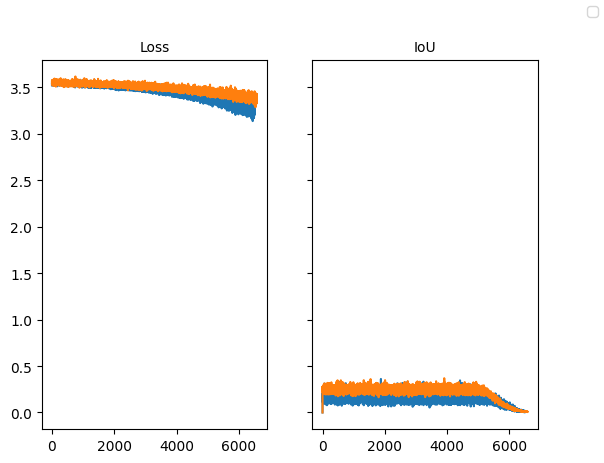

In [40]:
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2, sharey=True)
ax1.plot(history['train_loss'][::7])
ax1.plot(history['val_loss'])
ax1.set_title('Loss', fontsize='medium')
ax2.plot(history['train_iou'][::7])
ax2.plot(history['val_iou'])
ax2.set_title('IoU', fontsize='medium')
fig.legend()

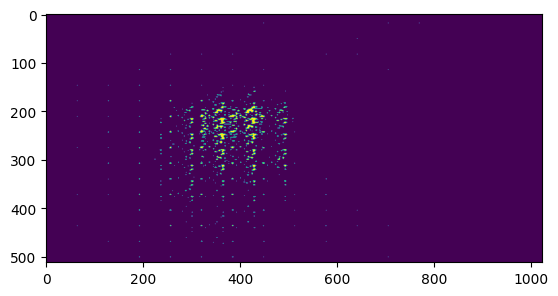

In [46]:
model.eval()
torch.cuda.empty_cache()
softmax = nn.Softmax(dim=-1)
with torch.no_grad():
    example = torch.Tensor(np.array([val_ds[5][0]])).to(device)
    pred = model(example)
    pred = pred.cpu()
    plt.imshow(mask_from_pred(pred[0]))